![Astrofisica Computacional](../logo.png)

---
## 22. Multilinear Fit with SciKit-Learn. Example 3


Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### About this notebook

In this worksheet, we will use the `scikit-learn` package split a sample database of 88 supermassive black holes into train and test sets in order to implement a multidimensional simple linear regression, a Ridge regression and a Lasso regression.

---

In [1]:
import numpy as np
from matplotlib import pyplot as plt
#import seaborn as sns
#sns.set()
import pandas as pd
from astropy.io import ascii

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# No warnings
import warnings
warnings.filterwarnings('ignore')

### Green and Ho data

Consider the dataset reported by Greene and Ho (2006), containing the features of 88 galaxies. 

Greene, J. E. and Ho, L. C. *The MBH − σ∗ Relation in Local Active Galaxies*. ApJ 641 L21 (2006)
https://ui.adsabs.harvard.edu/abs/2006ApJ...641L..21G/abstract

The dataset is available online in various formats at

http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/ApJ/641/L21.


We read the data using the `astropy.io.ascii` function.

In [2]:
data = ascii.read('SMBHData/table1.dat', readme='SMBHData/ReadMe')
data

Name,z,sigma*,e_sigma*,n_sigma*,FWHM,e_FWHM,logL,e_logL,logM,E_logM,e_logM
,,km / s,km / s,,km / s,km / s,[10-7W],[10-7W],dex(Msun),dex(Msun),dex(Msun)
str24,float64,float64,float64,str1,int64,int64,float64,float64,float64,float64,float64
SDSS J000805.62+145023.4,0.0454,140.0,27.0,--,7610,380,41.13,0.04,7.7,--,0.1
SDSS J004236.86-104921.8,0.0419,78.4,10.0,--,1960,97,41.58,0.14,6.7,--,0.1
SDSS J011703.58+000027.3,0.0456,98.8,16.0,--,2270,110,41.45,0.08,6.8,--,0.1
SDSS J020459.25-080816.0,0.0772,121.0,9.4,a,3720,180,41.13,0.05,7.0,--,0.1
SDSS J020615.99-001729.1,0.0426,216.0,30.0,--,3860,190,41.91,0.07,7.5,--,0.1
SDSS J021011.49-090335.5,0.0414,122.0,12.0,a,2450,120,41.24,0.07,6.7,--,0.1
...,...,...,...,...,...,...,...,...,...,...,...
NGC 4051,0.00234,88.9,2.9,--,--,--,--,--,5.99,0.17,0.2


Now, we convert the astropy Table to a pandas dataframe using the `.to_pandas()` method. Details at

https://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table.to_pandas

In [3]:
df = data.to_pandas()
df.describe()

,z,sigma*,e_sigma*,FWHM,e_FWHM,logL,e_logL,logM,E_logM,e_logM
count,88.000000,88.000000,88.000000,71.000000,71.000000,71.000000,71.000000,88.00000,15.000000,88.000000
mean,0.048665,117.142045,11.805682,3206.056338,210.760563,41.504225,0.078028,6.86625,0.140667,0.189886
std,0.032562,48.285108,5.308383,1759.679743,191.219953,0.663268,0.041700,0.72825,0.074303,0.172470
min,0.000947,30.000000,2.900000,810.000000,41.000000,40.100000,0.030000,4.90000,0.020000,0.020000
25%,0.027750,87.025000,7.750000,1905.000000,110.000000,41.155000,0.050000,6.30000,0.100000,0.100000
50%,0.042250,113.500000,12.000000,2970.000000,160.000000,41.510000,0.070000,7.00000,0.120000,0.100000
75%,0.062200,139.250000,15.000000,3870.000000,210.000000,41.860000,0.090000,7.40750,0.170000,0.200000
max,0.184000,268.000000,30.000000,8240.000000,1190.000000,43.610000,0.200000,8.52000,0.310000,1.060000


The dataframe includes data from 88 supermassive black holes. The columns correspond to

**z** : Redshift \
**sigma**\* : Stellar velocity dispersion \
**e_sigma**\* : Formal uncertainty in sigma* \
**FWHM** : H<sub>$\alpha$</sub> Full-Width at Half Maximum \
**e_FWHM** : Formal uncertainty in FWHM \
**logL** : $\log_{10}$ of H<sub>$\alpha$</sub> luminosity in erg/s \
**e_logL** : Formal uncertainty in logL \
**logM** : $\log_{10}$ of the Black Hole mass \
**E_logM** : Formal (upper limit) uncertainty in logM \
**e_logM** : Formal (lower limit) uncertainty in logM 


We will make a linear fit between the variables $\log M$ and $\log \left( \frac{\sigma_*}{\sigma_0} \right)$ and between the varibles $\log M$ and $\log  \text{FWHM} $, where $\sigma_0 = 200.$ is a reference value given by the authors. Hence, we add the corresponding columns to the dataframe.

In [4]:
sigma0 = 200.
df['logsigma*'] = np.log10(df['sigma*']/sigma0)
df['logFWHM'] = np.log10(df['FWHM'])
df.describe()

,z,sigma*,e_sigma*,FWHM,e_FWHM,logL,e_logL,logM,E_logM,e_logM,logsigma*,logFWHM
count,88.000000,88.000000,88.000000,71.000000,71.000000,71.000000,71.000000,88.00000,15.000000,88.000000,88.000000,71.000000
mean,0.048665,117.142045,11.805682,3206.056338,210.760563,41.504225,0.078028,6.86625,0.140667,0.189886,-0.272206,3.440999
std,0.032562,48.285108,5.308383,1759.679743,191.219953,0.663268,0.041700,0.72825,0.074303,0.172470,0.195820,0.246118
min,0.000947,30.000000,2.900000,810.000000,41.000000,40.100000,0.030000,4.90000,0.020000,0.020000,-0.823909,2.908485
25%,0.027750,87.025000,7.750000,1905.000000,110.000000,41.155000,0.050000,6.30000,0.100000,0.100000,-0.361386,3.279893
50%,0.042250,113.500000,12.000000,2970.000000,160.000000,41.510000,0.070000,7.00000,0.120000,0.100000,-0.246038,3.472756
75%,0.062200,139.250000,15.000000,3870.000000,210.000000,41.860000,0.090000,7.40750,0.170000,0.200000,-0.157237,3.587710
max,0.184000,268.000000,30.000000,8240.000000,1190.000000,43.610000,0.200000,8.52000,0.310000,1.060000,0.127105,3.915927


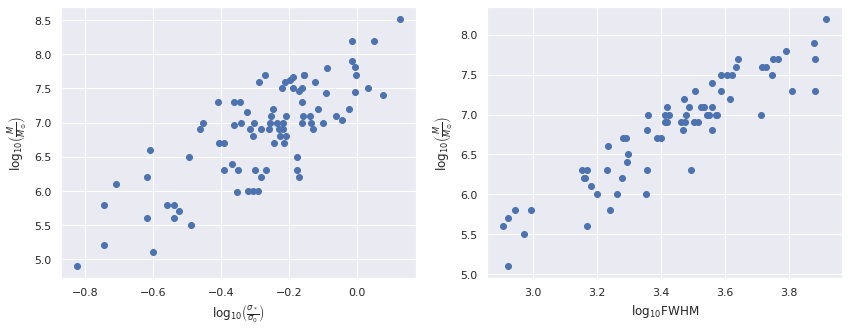

In [9]:

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].scatter(df['logsigma*'], df['logM'])
ax[0].set_xlabel(r'$\log _{10} \left(\frac{\sigma_*}{\sigma_0} \right)$')
ax[0].set_ylabel(r'$\log _{10} \left(\frac{M}{M_{\odot}} \right)$')

ax[1].scatter(df['logFWHM'], df['logM'])
ax[1].set_xlabel(r'$\log _{10}$FWHM')
ax[1].set_ylabel(r'$\log _{10} \left(\frac{M}{M_{\odot}} \right)$')

plt.show()

### Multidimensional Linear Fit using  `scikit-learn`

From the `scikit-learn.linear_model` package, we will import the function `LinearRegression`. Complete documentation about it can be found at

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

This function fits a linear model to minimize the residual sum of squares between the observed targets in the dataset and the targets predicted by the linear approximation (ordinary least squares fit).

Before making the fit, we need to prepare our data. First, we handle the missing values in the features,

In [5]:
newdf = df[['logM','logsigma*','logFWHM']]
newdf = newdf.apply (pd.to_numeric, errors='coerce')
newdf = newdf.dropna()
newdf.describe()

,logM,logsigma*,logFWHM
count,71.000000,71.000000,71.000000
mean,6.819718,-0.286024,3.440999
std,0.660653,0.176979,0.246118
min,5.100000,-0.744727,2.908485
25%,6.300000,-0.380551,3.279893
50%,6.900000,-0.255707,3.472756
75%,7.300000,-0.161151,3.587710
max,8.200000,0.077368,3.915927


Now, we define two new dataframes with the important features for the linear model. We use the capital letter X to identify the independent parameter data because it will be an array for the multidimensional fit.

In [6]:
Xdf = newdf[['logsigma*','logFWHM']]
ydf = newdf[['logM']]

We have 71 samples with three features. 

In [7]:
Xdf.describe() 

,logsigma*,logFWHM
count,71.000000,71.000000
mean,-0.286024,3.440999
std,0.176979,0.246118
min,-0.744727,2.908485
25%,-0.380551,3.279893
50%,-0.255707,3.472756
75%,-0.161151,3.587710
max,0.077368,3.915927


In [8]:
ydf.describe()

,logM
count,71.000000
mean,6.819718
std,0.660653
min,5.100000
25%,6.300000
50%,6.900000
75%,7.300000
max,8.200000


We will separate the dataframes into two sets, a training set and a testing set. We will use the function `train_test_split` function from the `sklearn.model_selection` package. We will use a size of 10% for the test set. More information on this function at

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf, random_state=60, test_size=0.15)

We obtained the following sets 

In [11]:
X_train.shape , y_train.shape

((60, 2), (60, 1))

In [12]:
X_test.shape , y_test.shape

((11, 2), (11, 1))

Now, we train the linear model

$y = \theta_0 + \theta_1 x_1 + \theta_2 x_2$ ,

with the method `LinearRegression().fit()` and the training data

In [13]:
lr = LinearRegression().fit(X_train, y_train)

The parameters obtained from the lienar fit are recovered with the methods `.intercept_` ($\theta_0$) and `.coef_` ($\theta_1$ and $\theta_2$).

In [14]:
lr.intercept_ , lr.coef_ 

(array([-0.25101491]), array([[0.67319112, 2.10630893]]))

Using the method `.score()`, which returns the coefficient of determination $R^2$ for the model, we obtain, for the training and the testing sets, the following results

In [15]:
lr.score(X_train, y_train)

0.8729674784840312

In [16]:
lr.score(X_test, y_test)

0.8417062908502944

#### Score of the linear model depending on the train set size


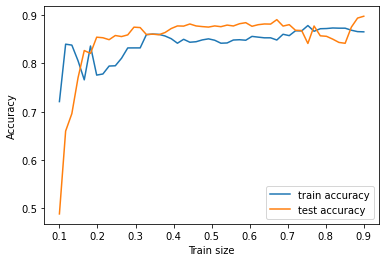

In [17]:
training_acc = []
test_acc = []

training_size = np.linspace(0.1,0.9,50)

for s in training_size:
    X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf, random_state=60, train_size=s)
    lr = LinearRegression().fit(X_train, y_train)
    training_acc.append(lr.score(X_train,y_train))
    test_acc.append(lr.score(X_test,y_test))
    
plt.plot(training_size, training_acc, label='train accuracy')
plt.plot(training_size, test_acc, label='test accuracy')
plt.xlabel(r'Train size')
plt.ylabel(r'Accuracy')
plt.legend()
plt.show()

---
### Ridge Regression
From the `scikit-learn.linear_model` package, we will import the function `Ridge`. Complete documentation about it can be found at

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

This function fits a linear model to minimize the residual sum of squares between the observed targets in the dataset and the targets predicted by the linear approximation (ordinary least squares fit), but it is regularized with the L2-norm.

In [23]:
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf, random_state=50, test_size=0.1)
ridge = Ridge().fit(X_train, y_train)

ridge.intercept_ , ridge.coef_

(array([1.30881024]), array([[0.73352909, 1.66082617]]))

In [24]:
ridge.score(X_train, y_train)

0.8467388608967501

In [25]:
ridge.score(X_test, y_test)

0.7815643586220277

#### Score of the linear model depending on the train set size

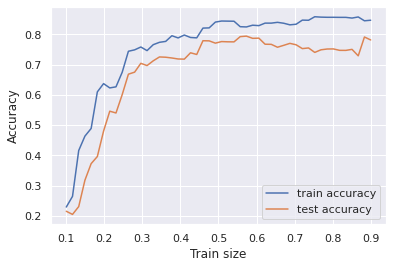

In [26]:
training_acc = []
test_acc = []

training_size = np.linspace(0.1,0.9,50)

for s in training_size:
    X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf, random_state=50, train_size=s)
    ridge = Ridge().fit(X_train, y_train)
    training_acc.append(ridge.score(X_train,y_train))
    test_acc.append(ridge.score(X_test,y_test))
    
plt.plot(training_size, training_acc, label='train accuracy')
plt.plot(training_size, test_acc, label='test accuracy')
plt.xlabel(r'Train size')
plt.ylabel(r'Accuracy')
plt.legend()
plt.show()

---
### Lasso Regression

From the `scikit-learn.linear_model` package, we will import the function `Lasso`. Complete documentation about it can be found at

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

This function fits a linear model to minimize the residual sum of squares between the observed targets in the dataset and the targets predicted by the linear approximation (ordinary least squares fit), but it is regularized with the L1-norm.

In [27]:
from sklearn.linear_model import Lasso
X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf, random_state=50, test_size=0.1)
lasso = Lasso(alpha=0.1).fit(X_train, y_train)

lasso.intercept_ , lasso.coef_

(array([3.99862395]), array([0.        , 0.81525713]))

In [28]:
lasso.score(X_train, y_train)

0.476069989399779

In [29]:
lasso.score(X_test, y_test)

0.3439250250734584

#### Score of the linear model depending on the train set size


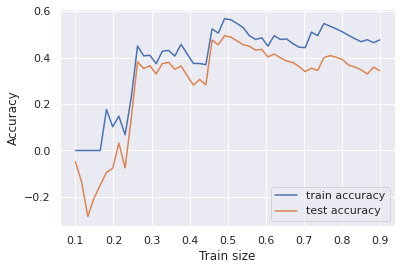

In [30]:
training_acc = []
test_acc = []

training_size = np.linspace(0.1,0.9,50)

for s in training_size:
    X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf, random_state=50, train_size=s)
    lasso = Lasso(alpha=0.1).fit(X_train, y_train)
    training_acc.append(lasso.score(X_train,y_train))
    test_acc.append(lasso.score(X_test,y_test))
    
plt.plot(training_size, training_acc, label='train accuracy')
plt.plot(training_size, test_acc, label='test accuracy')
plt.xlabel(r'Train size')
plt.ylabel(r'Accuracy')
plt.legend()
plt.show()